# Azure AI Human Detection Pipeline

Amanda Sumner  
September 2025

This Jupyter Notebook serves as a detailed analysis of the results from the **Azure AI human detection pipeline**. Its primary purpose is to load and process the JSON reports generated by the Azure Function. The analysis aims to demonstrate the pipeline's functionality and provide insights into the behaviour of the **Azure AI Vision** service on a sample dataset.

## Setup and data loading

In [1]:
from azure.storage.blob import BlobServiceClient
import os
import json
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [2]:
load_dotenv(dotenv_path=".env")

connect_str = os.getenv("AzureWebJobsStorage")
blob_service_client = BlobServiceClient.from_connection_string(connect_str)
container_client = blob_service_client.get_container_client("analysis-results")

reports = []
blob_list = container_client.list_blobs()
for blob in blob_list:
    download_stream = container_client.get_blob_client(blob).download_blob()
    json_data = json.loads(download_stream.readall())
    reports.append(json_data)

df = pd.DataFrame(reports)
print(f"Loaded {len(df)} reports.")

Loaded 30 reports.


In [3]:
df.head(10)


,image_name,human_detected,detection_details
0,1.png,True,"[{'confidence': 0.8913525342941284, 'bounding_..."
1,101.png,True,"[{'confidence': 0.9336774945259094, 'bounding_..."
2,102.png,True,"[{'confidence': 0.040830761194229126, 'boundin..."
3,11.png,True,"[{'confidence': 0.93868088722229, 'bounding_bo..."
4,111.png,True,"[{'confidence': 0.9183581471443176, 'bounding_..."
5,112.png,True,"[{'confidence': 0.006021004170179367, 'boundin..."
6,121.png,True,"[{'confidence': 0.9294695258140564, 'bounding_..."
7,126.png,True,"[{'confidence': 0.002122970763593912, 'boundin..."
8,131.png,True,"[{'confidence': 0.940255880355835, 'bounding_b..."
9,132.png,True,"[{'confidence': 0.7138572931289673, 'bounding_..."


In [4]:
# Setting a confidence threshold
threshold = 0.1

# Filtering the detection_details to only keep those above the threshold
df['detection_details'] = df['detection_details'].apply(
    lambda details: [d for d in details if d['confidence'] >= threshold]
)

df['human_detected'] = df['detection_details'].apply(lambda x: len(x) > 0)

In [7]:
# Define the local file path to save the DataFrame
local_file_path = 'reports_dataframe.pkl'

# Save the DataFrame to a pickle file
df.to_pickle(local_file_path)

print(f"DataFrame saved to {local_file_path}")

DataFrame saved to reports_dataframe.pkl


In [5]:
# Create a new DataFrame with each detection as a separate row
df_exploded = df.explode('detection_details').reset_index(drop=True)

# Now extract the confidence and bounding box into new columns
df_exploded['confidence'] = df_exploded['detection_details'].apply(
    lambda x: x['confidence'] if isinstance(x, dict) else None
)
df_exploded['bounding_box'] = df_exploded['detection_details'].apply(
    lambda x: x['bounding_box'] if isinstance(x, dict) else None
)

# Filter out rows that have no detections
df_exploded.dropna(subset=['confidence'], inplace=True)

# Display the first few rows of the new, exploded DataFrame
print(df_exploded[['image_name', 'confidence', 'bounding_box']].head())

  image_name  confidence                                       bounding_box
0      1.png    0.891353   {'x': 146, 'y': 58, 'width': 263, 'height': 505}
1      1.png    0.519207   {'x': 581, 'y': 198, 'width': 58, 'height': 223}
2    101.png    0.933677  {'x': 297, 'y': 121, 'width': 154, 'height': 370}
3    101.png    0.384692  {'x': 660, 'y': 311, 'width': 105, 'height': 201}
5     11.png    0.938681    {'x': 77, 'y': 64, 'width': 120, 'height': 272}


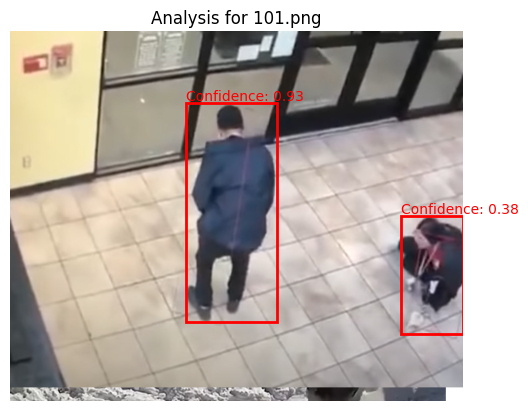

In [6]:
# The path to the local image file
image_path = '../samples/images/101.png'
image_filename = os.path.basename(image_path)

# Find the corresponding analysis report in your DataFrame
try:
    analysis_report = df[df['image_name'] == image_filename].iloc[0]
except IndexError:
    print(f"Error: No analysis report found for {image_filename} in the DataFrame.")
    analysis_report = None

if analysis_report is not None:
    # Open the local image file
    img = Image.open(image_path)

    # Create the plot
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Iterate through the detection details and draw bounding boxes
    for detail in analysis_report['detection_details']:
        # Get the bounding box coordinates
        bbox = detail['bounding_box']
        x, y, width, height = bbox['x'], bbox['y'], bbox['width'], bbox['height']

        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=2, edgecolor='r', facecolor='none'
        )

        # Add the rectangle to the axes
        ax.add_patch(rect)

        # Add a confidence label
        confidence = detail['confidence']
        plt.text(
            x, y - 5, f'Confidence: {confidence:.2f}', color='red', fontsize=10)
    plt.axis('off')  # Hide the axes
    plt.title(f'Analysis for {image_filename}')
    plt.show()